# Making our own colour-colour to mass-to-light ratio calibration

Isaac Cheng - November 2021

Using as many galaxies in the NGVS-VERTICO sample as possible in this lookup table.

Run the cell below then start from step 3.


In [1]:
# Need to switch directories if using VS Code + sshfs
LOOKUP_PATH = "/arc/home/IsaacCheng/coop_f2021/galaxies/lookup_table/"
%cd "$LOOKUP_PATH"
# 
import astropy.coordinates as coord
import astropy.units as u
import dill
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
from astropy.io import fits
from astropy.wcs import WCS
# 
# Load my own packages
# 
import sys
sys.path.append("/arc/home/IsaacCheng/coop_f2021/packages")
import fits_utils as fu
import plot_utils as pu
# 
GALDIST = 16.5 * u.Mpc  # distance to centre of Virgo cluster. Assume 10% uncertainty

/arc/home/IsaacCheng/coop_f2021/galaxies/lookup_table


# 1. Ensure each bin is only represented once (already done except for 2 galaxies)

i.e., each bin should be treated equally. Just because one Voronoi bin has 10x the pixels of the another, both are effectively "1 pixel" in our colour-colour space

Also, since some galaxies (i.e., NGC 4298 and NGC 4424) have overflow errors in the g-band (causing the SNR in the bin to be zero within floating point uncertainty), we will only consider bins that have SNRs >= 30.

NGC 4302 may have overflowed in i-band...


In [2]:
from numba import njit, prange
from itertools import repeat
from multiprocessing import Pool

@njit(parallel=False)  # will clash with multiprocessing if parallel=True
def select_one_from_each_bin(arr, bin_nums, unique_bin_nums):
    """
    Must ensure all incoming arrays are 1D (for numba)
    """
    tmp_arr_size = unique_bin_nums.size
    tmp_arr = np.full(tmp_arr_size, np.nan)
    for i, unique_bin_num in zip(prange(tmp_arr_size), unique_bin_nums):
        tmp_arr[i] = arr[bin_nums == unique_bin_num][0]
    return tmp_arr


def select_one_from_each_bin_multi(arr_of_arrs, bin_nums, processes=None):
    """
    arrs should be 1d array of arrays
    """
    unique_bin_nums = np.unique(bin_nums).astype(int)
    unique_bin_nums = np.sort(unique_bin_nums)
    print("Number of unique bins:", unique_bin_nums.size)
    print("Total(-ish) number of bins:", bin_nums.max() + 1)
    with Pool(processes=processes) as p:
        results = p.starmap(
            select_one_from_each_bin, zip(arr_of_arrs, repeat(bin_nums), repeat(unique_bin_nums))
        )
    return results, unique_bin_nums


tmp_arr2 = np.arange(11)
tmp_arr2 = select_one_from_each_bin(tmp_arr2, tmp_arr2.astype(int), tmp_arr2.astype(int))


In [3]:
# Set the following 2 variables
GALAXY = "NGC4216"
SNR_TARGET = 50  # specifies which Voronoi-binning file to use
# 
GALPATH = f"/arc/home/IsaacCheng/coop_f2021/galaxies/{GALAXY}/"
print("-" * 5, GALAXY, "-" * 5)
#
# Load Voronoi-binned data
#
vorbin_results = GALPATH + f"{GALAXY}_vorbin_SNR{SNR_TARGET}_ugizBinned.pkl"
with open(vorbin_results, "rb") as f:
    file = dill.load(f)
    uband_signal_vorbin = file["uband_signal"]
    uband_noise_vorbin = file["uband_noise"]
    gband_signal_vorbin = file["gband_signal"]
    gband_noise_vorbin = file["gband_noise"]
    iband_signal_vorbin = file["iband_signal"]
    iband_noise_vorbin = file["iband_noise"]
    zband_signal_vorbin = file["zband_signal"]
    zband_noise_vorbin = file["zband_noise"]
    px_per_vorbin = file["px_per_bin"]
    binNum_vorbin = file["binNum"]  # just to check how many original bins. Should be same as np.nanmax(binNum_arr_vorbin) + 1
    binNum_arr_vorbin = file["binNum_arr"]
#
# Select only 1 point from each bin (since bins have different sizes and are thus weighted
# differently if we don't do this)
# Also, only choose bins with SNR >= 30 and ensure all the array shapes match
#
uband_snr_vorbin = uband_signal_vorbin / uband_noise_vorbin
isgood_uband_snr = (uband_snr_vorbin >= 30) & np.isfinite(uband_snr_vorbin)
gband_snr_vorbin = gband_signal_vorbin / gband_noise_vorbin
isgood_gband_snr = (gband_snr_vorbin >= 30) & np.isfinite(gband_snr_vorbin)
iband_snr_vorbin = iband_signal_vorbin / iband_noise_vorbin
isgood_iband_snr = (iband_snr_vorbin >= 30) & np.isfinite(iband_snr_vorbin)
zband_snr_vorbin = zband_signal_vorbin / zband_noise_vorbin
isgood_zband_snr = (zband_snr_vorbin >= 30) & np.isfinite(zband_snr_vorbin)
# 
isgood_snr = (isgood_gband_snr) & (isgood_zband_snr) & (isgood_uband_snr) & (isgood_iband_snr)
# 
arr_of_bands = [
    uband_signal_vorbin[isgood_snr],
    uband_noise_vorbin[isgood_snr],
    gband_signal_vorbin[isgood_snr],
    gband_noise_vorbin[isgood_snr],
    iband_signal_vorbin[isgood_snr],
    iband_noise_vorbin[isgood_snr],
    zband_signal_vorbin[isgood_snr],
    zband_noise_vorbin[isgood_snr],
    px_per_vorbin[isgood_snr]
]
starttime = time.time()
arr_of_results, unique_binNum = select_one_from_each_bin_multi(
    arr_of_bands, binNum_arr_vorbin[isgood_snr].astype(int), processes=9
)
endtime = time.time()
print(f"It took {(endtime - starttime) / 60:.2f} minutes to finish this step")
# Save results
lookup_inputs_outfile = LOOKUP_PATH + f"{GALAXY}_lookupInputs.pkl"
with open(lookup_inputs_outfile, "wb") as f:
    dill.dump(
        {
            "uband_signal": arr_of_results[0],
            "uband_noise": arr_of_results[1],
            "gband_signal": arr_of_results[2],
            "gband_noise": arr_of_results[3],
            "iband_signal": arr_of_results[4],
            "iband_noise": arr_of_results[5],
            "zband_signal": arr_of_results[6],
            "zband_noise": arr_of_results[7],
            "bin_num": unique_binNum,
            "px_per_bin": arr_of_results[8],
        },
        f,
    )
print("Pickled", lookup_inputs_outfile)
print()
print("Number of good Voronoi bins:", arr_of_results[0].shape)

----- NGC4216 -----


Number of unique bins: 221250
Total(-ish) number of bins: 221412
It took 21.38 minutes to finish this step
Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/lookup_table/NGC4216_lookupInputs.pkl

Number of good Voronoi bins: (221250,)


In [4]:
print("-" * 5, "Results for", GALAXY, "-" * 5)
print("Number of good pixels", np.sum(isgood_snr), "\tTotal number of pixels:", uband_signal_vorbin.size)
print("Original number of bins:", binNum_vorbin.max() + 1)
print("Number of unique bins:", unique_binNum.size, "\tMaximum bin number:", unique_binNum.max())
print("Relative percentage of good bins:", unique_binNum.size / (binNum_vorbin.max() + 1) * 100)

----- Results for NGC4216 -----
Number of good pixels 3327307 	Total number of pixels: 3508128
Original number of bins: 221414
Number of unique bins: 221250 	Maximum bin number: 221411
Relative percentage of good bins: 99.92593060962722


In [5]:
print(np.min(arr_of_results[8]))
print(arr_of_results[8].dtype)
print(unique_binNum.dtype)

1.0
float64
int64


# 2. Compile all the galaxies' data into one array and correct for Galactic extinction (already done)

Note that I manually removed any g-z colours <= 0 (before extinction correction) for NGC
4216 since those colours correspond to the area around the unflagged foreground star.

For future analysis, it would be best if Voronoi binning was re-run on NGC 4216 except
with the foreground star already masked out (before beginning Voronoi binning).



In [ ]:
pd.set_option("max_columns", None)
pd.reset_option("max_rows")
ngvs_catalogue = pd.read_csv("/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS_catalogue.txt", sep=" ", low_memory=False)
ngvs_catalogue

In [3]:
GALAXIES = [
    "IC3392",
    # "NGC4189",  # ignored flag map, but bad results
    "NGC4192",
    "NGC4216",  # has unflagged foreground star
    "NGC4222",
    "NGC4254",
    "NGC4294",
    "NGC4298",
    "NGC4299",
    "NGC4302",
    "NGC4321",
    "NGC4330",
    "NGC4351",
    "NGC4380",
    "NGC4383",
    "NGC4388",
    "NGC4396",
    "NGC4402",
    "NGC4405",
    "NGC4419",
    "NGC4424",
    "NGC4450",
    "NGC4501",
    "NGC4522",
    "NGC4532",
    "NGC4535",
    "NGC4548",
    "NGC4567",
    "NGC4568",
    "NGC4569",
    "NGC4579",
    "NGC4580",
    # "NGC4606",  # flag map too intrusive
    "NGC4607",
    "NGC4651",
    "NGC4654",
    "NGC4689",
    "NGC4694",
]
VCC_GALAXIES = [
    1126,  # IC3392
    # 89,  # NGC4189, ignored flag map, but bad results
    92,  # NGC4192
    167,  # NGC4216, has unflagged foreground star
    187,  # NGC4222
    307,  # NGC4254
    465,  # NGC4294
    483,  # NGC4298
    491,  # NGC4299
    497,  # NGC4302
    596,  # NGC4321
    630,  # NGC4330
    692,  # NGC4351
    792,  # NGC4380
    801,  # NGC4383
    836,  # NGC4388
    865,  # NGC4396
    873,  # NGC4402
    874,  # NGC4405
    958,  # NGC4419
    979,  # NGC4424
    1110,  # NGC4450
    1401,  # NGC4501
    1516,  # NGC4522
    1554,  # NGC4532
    1555,  # NGC4535
    1615,  # NGC4548
    1673,  # NGC4567
    1676,  # NGC4568
    1690,  # NGC4569
    1727,  # NGC4579
    1730,  # NGC4580
    # 1859,  # NGC4606, flag map too intrusive
    1868,  # NGC4607
    -100,  # NGC4651 (EVCC number is 1102, cannot use EVCC number)
    1987,  # NGC4654
    2058,  # NGC4689
    2066,  # NGC4694
]

ngvs_ra = ngvs_catalogue["NGVS_ra(deg)"]
ngvs_dec = ngvs_catalogue["NGVS_dec(deg)"]
vcc_name = ngvs_catalogue["VCC_name"]
extinctions = ngvs_catalogue["e(B-V)"]

# Single entry that is closest to NGC4651 coordinates
NGC4651_row = vcc_name[
    (abs(ngvs_ra - 190.927625) < 0.1) & (abs(ngvs_dec - 16.39338889) < 0.1)
].index.values[0]

# E(B-V) to u, g, i, z extinction coefficients
# (from http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/community/ngvs/query/catdoc.html#ebv)
EBV_u = 4.594
EBV_g = 3.560
EBV_i = 1.813
EBV_z = 1.221


In [4]:
rel_to_abs_mag = 5 * (np.log10(GALDIST.to(u.pc).value) - 1)

uband_abs_mag = np.array([], dtype=float)
uband_abs_mag_err = np.array([], dtype=float)
gband_abs_mag = np.array([], dtype=float)
gband_abs_mag_err = np.array([], dtype=float)
iband_abs_mag = np.array([], dtype=float)
iband_abs_mag_err = np.array([], dtype=float)
zband_abs_mag = np.array([], dtype=float)
zband_abs_mag_err = np.array([], dtype=float)
bin_num = np.array([], dtype=int)
px_per_bin = np.array([], dtype=float)
gz_colour = np.array([], dtype=float)
gz_colour_err = np.array([], dtype=float)
ui_colour = np.array([], dtype=float)
ui_colour_err = np.array([], dtype=float)

for gal, vcc_gal in zip(GALAXIES, VCC_GALAXIES):
    # print(f"On {gal} (aka VCC {vcc_gal})")
    # 
    # Load data
    # 
    with open(LOOKUP_PATH + f"{gal}_lookupInputs.pkl", "rb") as f:
        file = dill.load(f)
        uband_signal = file["uband_signal"]
        uband_noise = file["uband_noise"]
        gband_signal = file["gband_signal"]
        gband_noise = file["gband_noise"]
        iband_signal = file["iband_signal"]
        iband_noise = file["iband_noise"]
        zband_signal = file["zband_signal"]
        zband_noise = file["zband_noise"]
        tmp_bin_num = file["bin_num"]
        tmp_px_per_bin = file["px_per_bin"]
    if gal == "NGC4216":
        # Manually remove g-z colours <= 0 for NGC 4216
        # (i.e., colours corresponding to area around foreground star)
        is_good = fu.calc_colour(gband_signal, zband_signal) > 0
        uband_signal = uband_signal[is_good]
        uband_noise = uband_noise[is_good]
        gband_signal = gband_signal[is_good]
        gband_noise = gband_noise[is_good]
        iband_signal = iband_signal[is_good]
        iband_noise = iband_noise[is_good]
        zband_signal = zband_signal[is_good]
        zband_noise = zband_noise[is_good]
        tmp_bin_num = tmp_bin_num[is_good]
        tmp_px_per_bin = tmp_px_per_bin[is_good]
    # 
    # Normalize fluxes by number of pixels
    # 
    uband_signal = uband_signal / tmp_px_per_bin
    uband_noise = uband_noise / tmp_px_per_bin
    gband_signal = gband_signal / tmp_px_per_bin
    gband_noise = gband_noise / tmp_px_per_bin
    iband_signal = iband_signal / tmp_px_per_bin
    iband_noise = iband_noise / tmp_px_per_bin
    zband_signal = zband_signal / tmp_px_per_bin
    zband_noise = zband_noise / tmp_px_per_bin
    # 
    # Calculate relative AB magnitudes
    # 
    tmp_uband_relmag, tmp_uband_mag_err = fu.calc_mag(uband_signal, uband_noise, calc_abs=False)
    tmp_gband_relmag, tmp_gband_mag_err = fu.calc_mag(gband_signal, gband_noise, calc_abs=False)
    tmp_iband_relmag, tmp_iband_mag_err = fu.calc_mag(iband_signal, iband_noise, calc_abs=False)
    tmp_zband_relmag, tmp_zband_mag_err = fu.calc_mag(zband_signal, zband_noise, calc_abs=False)
    # 
    # Correct for extinction
    # 
    if gal != "NGC4651":
        ebv_coeff = extinctions[vcc_name == vcc_gal].values
        if ebv_coeff.size != 1:
            raise ValueError(f"More than one E(B-V) coefficient found for {gal}")
        ebv_coeff = ebv_coeff[0]
    else:
        ebv_coeff = extinctions.iloc[NGC4651_row]
    tmp_uband_relmag = tmp_uband_relmag - ebv_coeff * EBV_u
    tmp_gband_relmag = tmp_gband_relmag - ebv_coeff * EBV_g
    tmp_iband_relmag = tmp_iband_relmag - ebv_coeff * EBV_i
    tmp_zband_relmag = tmp_zband_relmag - ebv_coeff * EBV_z
    # 
    # Calculate colours
    # 
    tmp_gz_colour = tmp_gband_relmag - tmp_zband_relmag
    tmp_ui_colour = tmp_uband_relmag - tmp_iband_relmag
    tmp_gz_colour_err = np.sqrt(tmp_gband_mag_err ** 2 + tmp_zband_mag_err ** 2)
    tmp_ui_colour_err = np.sqrt(tmp_uband_mag_err ** 2 + tmp_iband_mag_err ** 2)
    # 
    # Convert to absolute AB magnitudes, assuming no distance uncertainty
    # 
    tmp_uband_absmag = tmp_uband_relmag - rel_to_abs_mag
    tmp_gband_absmag = tmp_gband_relmag - rel_to_abs_mag
    tmp_iband_absmag = tmp_iband_relmag - rel_to_abs_mag
    tmp_zband_absmag = tmp_zband_relmag - rel_to_abs_mag
    # 
    # Add to arrays
    # 
    uband_abs_mag = np.append(uband_abs_mag, tmp_uband_absmag)
    uband_abs_mag_err = np.append(uband_abs_mag_err, tmp_uband_mag_err)
    gband_abs_mag = np.append(gband_abs_mag, tmp_gband_absmag)
    gband_abs_mag_err = np.append(gband_abs_mag_err, tmp_gband_mag_err)
    iband_abs_mag = np.append(iband_abs_mag, tmp_iband_absmag)
    iband_abs_mag_err = np.append(iband_abs_mag_err, tmp_iband_mag_err)
    zband_abs_mag = np.append(zband_abs_mag, tmp_zband_absmag)
    zband_abs_mag_err = np.append(zband_abs_mag_err, tmp_zband_mag_err)
    gz_colour = np.append(gz_colour, tmp_gz_colour)
    gz_colour_err = np.append(gz_colour_err, tmp_gz_colour_err)
    ui_colour = np.append(ui_colour, tmp_ui_colour)
    ui_colour_err = np.append(ui_colour_err, tmp_ui_colour_err)
    bin_num = np.append(bin_num, tmp_bin_num)
    px_per_bin = np.append(px_per_bin, tmp_px_per_bin)
file = None  # free memory
px_per_bin = px_per_bin.astype(int)
# 
# Save compiled arrays
# 
total_lookup_inputs_outfile = LOOKUP_PATH + "TOTAL_no4189_extinctionCorr_lookupInputs.pkl"
with open(total_lookup_inputs_outfile, "wb") as f:
    dill.dump(
        {
            "uband_abs_mag": uband_abs_mag,
            "uband_abs_mag_err": uband_abs_mag_err,
            "gband_abs_mag": gband_abs_mag,
            "gband_abs_mag_err": gband_abs_mag_err,
            "iband_abs_mag": iband_abs_mag,
            "iband_abs_mag_err": iband_abs_mag_err,
            "zband_abs_mag": zband_abs_mag,
            "zband_abs_mag_err": zband_abs_mag_err,
            "gz_colour": gz_colour,
            "gz_colour_err": gz_colour_err,
            "ui_colour": ui_colour,
            "ui_colour_err": ui_colour_err,
            "bin_num": bin_num,
            "px_per_bin": px_per_bin,
        },
        f
    )
print("Pickled", total_lookup_inputs_outfile)

Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/lookup_table/TOTAL_no4189_extinctionCorr_lookupInputs.pkl


# (OLD. DO NOT USE) 2. Compile all the galaxies' data into one array (already done)

Note that I manually removed any g-z colours <= 0 for NGC 4216 since those colours
correspond to the area around the unflagged foreground star.

For future analysis, it would be best if Voronoi binning was re-run on NGC 4216 except
with the foreground star already masked out (before beginning Voronoi binning).


In [2]:
GALAXIES = [
    "IC3392",
    # "NGC4189",  # ignored flag map, but bad results
    "NGC4192",
    "NGC4216",  # has unflagged foreground star
    "NGC4222",
    "NGC4254",
    "NGC4294",
    "NGC4298",
    "NGC4299",
    "NGC4302",
    "NGC4321",
    "NGC4330",
    "NGC4351",
    "NGC4380",
    "NGC4383",
    "NGC4388",
    "NGC4396",
    "NGC4402",
    "NGC4405",
    "NGC4419",
    "NGC4424",
    "NGC4450",
    "NGC4501",
    "NGC4522",
    "NGC4532",
    "NGC4535",
    "NGC4548",
    "NGC4567",
    "NGC4568",
    "NGC4569",
    "NGC4579",
    "NGC4580",
    # "NGC4606",  # flag map too intrusive
    "NGC4607",
    "NGC4651",
    "NGC4654",
    "NGC4689",
    "NGC4694",
]
uband_signal = np.array([], dtype=float)
uband_noise = np.array([], dtype=float)
gband_signal = np.array([], dtype=float)
gband_noise = np.array([], dtype=float)
iband_signal = np.array([], dtype=float)
iband_noise = np.array([], dtype=float)
zband_signal = np.array([], dtype=float)
zband_noise = np.array([], dtype=float)
bin_num = np.array([], dtype=int)
px_per_bin = np.array([], dtype=float)
for gal in GALAXIES:
    with open(LOOKUP_PATH + f"{gal}_lookupInputs.pkl", "rb") as f:
        file = dill.load(f)
        # Load everything here
        tmp_usig = file["uband_signal"]
        tmp_unoise = file["uband_noise"]
        tmp_gsig = file["gband_signal"]
        tmp_gnoise = file["gband_noise"]
        tmp_isig = file["iband_signal"]
        tmp_inoise = file["iband_noise"]
        tmp_zsig = file["zband_signal"]
        tmp_znoise = file["zband_noise"]
        tmp_bin_num = file["bin_num"]
        tmp_px_per_bin = file["px_per_bin"]
        if gal == "NGC4216":
            # Manually remove g-z colours <= 0 for NGC 4216
            # (i.e., colours corresponding to area around foreground star)
            is_good = fu.calc_colour(tmp_gsig, tmp_zsig) > 0
            tmp_usig = tmp_usig[is_good]
            tmp_unoise = tmp_unoise[is_good]
            tmp_gsig = tmp_gsig[is_good]
            tmp_gnoise = tmp_gnoise[is_good]
            tmp_isig = tmp_isig[is_good]
            tmp_inoise = tmp_inoise[is_good]
            tmp_zsig = tmp_zsig[is_good]
            tmp_znoise = tmp_znoise[is_good]
            tmp_bin_num = tmp_bin_num[is_good]
            tmp_px_per_bin = tmp_px_per_bin[is_good]
        # Add to existing arrays
        uband_signal = np.append(uband_signal, tmp_usig)
        uband_noise = np.append(uband_noise, tmp_unoise)
        gband_signal = np.append(gband_signal, tmp_gsig)
        gband_noise = np.append(gband_noise, tmp_gnoise)
        iband_signal = np.append(iband_signal, tmp_isig)
        iband_noise = np.append(iband_noise, tmp_inoise)
        zband_signal = np.append(zband_signal, tmp_zsig)
        zband_noise = np.append(zband_noise, tmp_znoise)
        bin_num = np.append(bin_num, tmp_bin_num)
        px_per_bin = np.append(px_per_bin, tmp_px_per_bin)
px_per_bin = px_per_bin.astype(int)
# 
# Save compiled arrays
# 
total_lookup_inputs_outfile = LOOKUP_PATH + f"TOTAL_no4189_lookupInputs.pkl"
with open(total_lookup_inputs_outfile, "wb") as f:
    dill.dump(
        {
            "uband_signal": uband_signal,
            "uband_noise": uband_noise,
            "gband_signal": gband_signal,
            "gband_noise": gband_noise,
            "iband_signal": iband_signal,
            "iband_noise": iband_noise,
            "zband_signal": zband_signal,
            "zband_noise": zband_noise,
            "bin_num": bin_num,
            "px_per_bin": px_per_bin,
        },
        f
    )
print("Pickled", total_lookup_inputs_outfile)

Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/lookup_table/TOTAL_no4189_lookupInputs.pkl


# 3. Load colours and magnitudes

Note that these data have been corrected for Galactic extinction


In [2]:
total_lookup_inputs_infile = LOOKUP_PATH + "TOTAL_no4189_extinctionCorr_lookupInputs.pkl"
with open(total_lookup_inputs_infile, "rb") as f:
    file = dill.load(f)
    uband_mag = file["uband_abs_mag"]
    uband_mag_err = file["uband_abs_mag_err"]
    gband_mag = file["gband_abs_mag"]
    gband_mag_err = file["gband_abs_mag_err"]
    iband_mag = file["iband_abs_mag"]
    iband_mag_err = file["iband_abs_mag_err"]
    zband_mag = file["zband_abs_mag"]
    zband_mag_err = file["zband_abs_mag_err"]
    gz_colour_vorbin = file["gz_colour"]
    ui_colour_vorbin = file["ui_colour"]
    # gz_colour_err_vorbin = file["gz_colour_err"]
    # ui_colour_err_vorbin = file["ui_colour_err"]
    bin_num = file["bin_num"]
    px_per_bin = file["px_per_bin"]
    file = None  # free memory

In [3]:
print(bin_num.shape, px_per_bin.shape, uband_mag.shape, uband_mag_err.shape, ui_colour_vorbin.shape)
print("g-z colour min/max:", np.min(gz_colour_vorbin), np.max(gz_colour_vorbin))
print("u-i colour min/max:", np.min(ui_colour_vorbin), np.max(ui_colour_vorbin))

(5918454,) (5918454,) (5918454,) (5918454,) (5918454,)
g-z colour min/max: -1.2256538571319524 3.7300316671962435
u-i colour min/max: -0.8281131267440962 5.719559364037664


# (OLD. DO NOT USE) 3. Calculate colours and magnitudes

Note that I have _not_ corrected for Galactic extinction in these data.


In [2]:
# 
# Load data
# 
total_lookup_inputs_infile = LOOKUP_PATH + "TOTAL_no4189_lookupInputs.pkl"
with open(total_lookup_inputs_infile, "rb") as f:
    file = dill.load(f)
    uband_signal = file["uband_signal"]
    uband_noise = file["uband_noise"]
    gband_signal = file["gband_signal"]
    gband_noise = file["gband_noise"]
    iband_signal = file["iband_signal"]
    iband_noise = file["iband_noise"]
    zband_signal = file["zband_signal"]
    zband_noise = file["zband_noise"]
    bin_num = file["bin_num"]
    px_per_bin = file["px_per_bin"]
    file = None  # free memory
# 
# Normalize fluxes by number of pixels
# 
uband_signal = uband_signal / px_per_bin
uband_noise = uband_noise / px_per_bin
gband_signal = gband_signal / px_per_bin
gband_noise = gband_noise / px_per_bin
iband_signal = iband_signal / px_per_bin
iband_noise = iband_noise / px_per_bin
zband_signal = zband_signal / px_per_bin
zband_noise = zband_noise / px_per_bin
# 
# Calculate colours
#
gz_colour_vorbin = fu.calc_colour(gband_signal, zband_signal)
ui_colour_vorbin = fu.calc_colour(uband_signal, iband_signal)
# 
# Calculate absolute magniutudes
# 
uband_mag, uband_mag_err = fu.calc_mag(uband_signal, uband_noise, calc_abs=True, dist=GALDIST.to(u.pc).value)
gband_mag, gband_mag_err = fu.calc_mag(gband_signal, gband_noise, calc_abs=True, dist=GALDIST.to(u.pc).value)
iband_mag, iband_mag_err = fu.calc_mag(iband_signal, iband_noise, calc_abs=True, dist=GALDIST.to(u.pc).value)
zband_mag, zband_mag_err = fu.calc_mag(zband_signal, zband_noise, calc_abs=True, dist=GALDIST.to(u.pc).value)

In [3]:
print("g-z colour min/max:", np.min(gz_colour_vorbin), np.max(gz_colour_vorbin))
print("u-i colour min/max:", np.min(ui_colour_vorbin), np.max(ui_colour_vorbin))

g-z colour min/max: -1.1802304771319492 3.7832439171962458
u-i colour min/max: -0.774106106744094 5.8116938940376635


# 4. Make hexbin plot


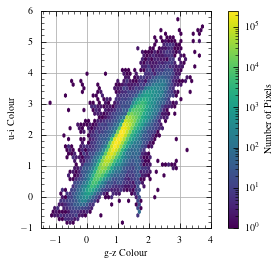

In [10]:
fig, ax = plt.subplots()
hb = ax.hexbin(
    gz_colour_vorbin.flatten(),
    ui_colour_vorbin.flatten(),
    gridsize=50,
    bins="log",  # will change the get_array() values
    mincnt=1,
    cmap="viridis",
    linewidths=0,
    # extent=[
    #     np.nanmin(gz_colour_vorbin),
    #     np.nanmax(gz_colour_vorbin),
    #     np.nanmin(ui_colour_vorbin),
    #     np.nanmax(ui_colour_vorbin),
    # ],
    zorder=2,
)
cbar = fig.colorbar(hb)
cbar.set_label("Number of Pixels")
ax.set_xlabel("g-z Colour")
ax.set_ylabel("u-i Colour")
ax.set_aspect("equal")
ax.set_xticks(np.arange(-1, 5).astype(int))
ax.set_ylim(-1, 6)
# ax.plot([-1, 4], [-1, 4], "k")  # y=x line
# fig.savefig(LOOKUP_PATH + f"TOTAL_no4189_ui_vs_gz_extinctionCorr_hexbin_v2.pdf")
plt.show()

/opt/conda/lib/python3.8/contextlib.py:113: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  return next(self.gen)


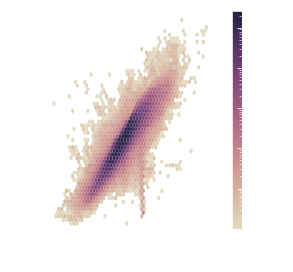

Done!


In [4]:
# 
# Version for beamer slides
#
# beamer_cmaps = ["autumn", "spring", "summer", "winter", "viridis"]
# beamer_cmaps = ["viridis"]
beamer_cmaps = [
    sns.color_palette("ch:s=-.2,r=.6", as_cmap=True),
#     sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True),
#     sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True),
#     sns.cubehelix_palette(as_cmap=True)
]
with plt.style.context("/arc/home/IsaacCheng/coop_f2021/stylesheets/beamer.mplstyle"):
    for beamer_cmap in beamer_cmaps:
        fig, ax = plt.subplots()
        hb = ax.hexbin(
            gz_colour_vorbin.flatten(),
            ui_colour_vorbin.flatten(),
            gridsize=50,
            bins="log",  # will change the get_array() values
            mincnt=1,
            cmap=beamer_cmap,
            linewidths=0,
            # extent=[
            #     np.nanmin(gz_colour_vorbin),
            #     np.nanmax(gz_colour_vorbin),
            #     np.nanmin(ui_colour_vorbin),
            #     np.nanmax(ui_colour_vorbin),
            # ],
            zorder=2,
        )
        cbar = fig.colorbar(hb)
        cbar.set_label("Number of Pixels")
        ax.set_xlabel("g-z Colour")
        ax.set_ylabel("u-i Colour")
        ax.set_aspect("equal")
        ax.set_xticks(np.arange(-1, 5).astype(int))
        ax.set_ylim(-1, 6)
        ax.grid(False)
        # ax.plot([-1, 4], [-1, 4], "k")  # y=x line
        # fig.savefig(LOOKUP_PATH + f"TOTAL_no4189_ui_vs_gz_extinctionCorr_hexbin_v2_beamer_{beamer_cmap}.pdf")
        # fig.savefig(LOOKUP_PATH + "TOTAL_no4189_ui_vs_gz_extinctionCorr_hexbin_v2_beamer.pdf")
        plt.show()
print("Done!")

## 4.1 Make hexbin plot of each galaxy overlaid on hexbin plot of all galaxies

Useful for finding which galaxy corresponds to which areas of our colour-colour space.

Not using contour plot for all galaxies because too many points (KDE plot takes too long).

Note that all the hexbin plots have been extinction-corrected.


In [ ]:
ngvs_catalogue = pd.read_csv("/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS_catalogue.txt", sep=" ", low_memory=False)
ngvs_catalogue

In [4]:
GALAXIES = [
    "IC3392",
    # "NGC4189",  # ignored flag map, but bad results
    "NGC4192",
    "NGC4216",  # has unflagged foreground star
    "NGC4222",
    "NGC4254",
    "NGC4294",
    "NGC4298",
    "NGC4299",
    "NGC4302",
    "NGC4321",
    "NGC4330",
    "NGC4351",
    "NGC4380",
    "NGC4383",
    "NGC4388",
    "NGC4396",
    "NGC4402",
    "NGC4405",
    "NGC4419",
    "NGC4424",
    "NGC4450",
    "NGC4501",
    "NGC4522",
    "NGC4532",
    "NGC4535",
    "NGC4548",
    "NGC4567",
    "NGC4568",
    "NGC4569",
    "NGC4579",
    "NGC4580",
    # "NGC4606",  # flag map too intrusive
    "NGC4607",
    "NGC4651",
    "NGC4654",
    "NGC4689",
    "NGC4694",
]
VCC_GALAXIES = [
    1126,  # IC3392
    # 89,  # NGC4189, ignored flag map, but bad results
    92,  # NGC4192
    167,  # NGC4216, has unflagged foreground star
    187,  # NGC4222
    307,  # NGC4254
    465,  # NGC4294
    483,  # NGC4298
    491,  # NGC4299
    497,  # NGC4302
    596,  # NGC4321
    630,  # NGC4330
    692,  # NGC4351
    792,  # NGC4380
    801,  # NGC4383
    836,  # NGC4388
    865,  # NGC4396
    873,  # NGC4402
    874,  # NGC4405
    958,  # NGC4419
    979,  # NGC4424
    1110,  # NGC4450
    1401,  # NGC4501
    1516,  # NGC4522
    1554,  # NGC4532
    1555,  # NGC4535
    1615,  # NGC4548
    1673,  # NGC4567
    1676,  # NGC4568
    1690,  # NGC4569
    1727,  # NGC4579
    1730,  # NGC4580
    # 1859,  # NGC4606, flag map too intrusive
    1868,  # NGC4607
    -100,  # NGC4651 (EVCC number is 1102, cannot use EVCC number)
    1987,  # NGC4654
    2058,  # NGC4689
    2066,  # NGC4694
]
INCLINATIONS = [
    68,
    # 42,  # ignored flag map, but bad results
    83,
    90,  # has unflagged foreground star
    90,
    39,
    74,
    52,
    14,
    90,
    32,
    90,
    48,
    61,
    56,
    83,
    83,
    80,
    46,
    74,
    61,
    51,
    65,
    82,
    64,
    48,
    37,
    49,
    70,
    69,
    40,
    46,
    # 69,  # flag map too intrusive
    90,
    53,
    61,
    38,
    62,
]

ngvs_ra = ngvs_catalogue["NGVS_ra(deg)"]
ngvs_dec = ngvs_catalogue["NGVS_dec(deg)"]
vcc_name = ngvs_catalogue["VCC_name"]
extinctions = ngvs_catalogue["e(B-V)"]

# Entry that is closest to NGC4651 coordinates
NGC4651_row = vcc_name[
    (abs(ngvs_ra - 190.927625) < 0.1) & (abs(ngvs_dec - 16.39338889) < 0.1)
].index.values[0]

# E(B-V) to u, g, i, z extinction coefficients
# (from http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/community/ngvs/query/catdoc.html#ebv)
EBV_u = 4.594
EBV_g = 3.560
EBV_i = 1.813
EBV_z = 1.221


In [5]:
import re
#
# Load data for 1 galaxy
# 
for galaxy, i, vcc_galaxy in zip(GALAXIES, INCLINATIONS, VCC_GALAXIES):
    galaxy_inputs_infile = LOOKUP_PATH + f"{galaxy}_lookupInputs.pkl"
    with open(galaxy_inputs_infile, "rb") as f:
        file = dill.load(f)
        gal_uband_signal = file["uband_signal"]
        gal_uband_noise = file["uband_noise"]
        gal_gband_signal = file["gband_signal"]
        gal_gband_noise = file["gband_noise"]
        gal_iband_signal = file["iband_signal"]
        gal_iband_noise = file["iband_noise"]
        gal_zband_signal = file["zband_signal"]
        gal_zband_noise = file["zband_noise"]
        gal_px_per_bin = file["px_per_bin"]
        file = None  # free memory
    if galaxy == "NGC4216":
        # Manually remove g-z colours <= 0 for NGC 4216
        # (i.e., colours corresponding to area around foreground star)
        is_good = fu.calc_colour(gal_gband_signal, gal_zband_signal) > 0
        gal_uband_signal = gal_uband_signal[is_good]
        gal_uband_noise = gal_uband_noise[is_good]
        gal_gband_signal = gal_gband_signal[is_good]
        gal_gband_noise = gal_gband_noise[is_good]
        gal_iband_signal = gal_iband_signal[is_good]
        gal_iband_noise = gal_iband_noise[is_good]
        gal_zband_signal = gal_zband_signal[is_good]
        gal_zband_noise = gal_zband_noise[is_good]
        gal_px_per_bin = gal_px_per_bin[is_good]
    # 
    # Normalize fluxes by number of pixels
    # 
    gal_uband_signal = gal_uband_signal / gal_px_per_bin
    gal_uband_noise = gal_uband_noise / gal_px_per_bin
    gal_gband_signal = gal_gband_signal / gal_px_per_bin
    gal_gband_noise = gal_gband_noise / gal_px_per_bin
    gal_iband_signal = gal_iband_signal / gal_px_per_bin
    gal_iband_noise = gal_iband_noise / gal_px_per_bin
    gal_zband_signal = gal_zband_signal / gal_px_per_bin
    gal_zband_noise = gal_zband_noise / gal_px_per_bin
    # 
    # Calculate relative AB magnitudes
    # 
    gal_uband_relmag, gal_uband_mag_err = fu.calc_mag(gal_uband_signal, gal_uband_noise, calc_abs=False)
    gal_gband_relmag, gal_gband_mag_err = fu.calc_mag(gal_gband_signal, gal_gband_noise, calc_abs=False)
    gal_iband_relmag, gal_iband_mag_err = fu.calc_mag(gal_iband_signal, gal_iband_noise, calc_abs=False)
    gal_zband_relmag, gal_zband_mag_err = fu.calc_mag(gal_zband_signal, gal_zband_noise, calc_abs=False)
    # 
    # Correct for extinction
    # 
    if galaxy != "NGC4651":
        ebv_coeff = extinctions[vcc_name == vcc_galaxy].values
        if ebv_coeff.size != 1:
            raise ValueError(f"More than one E(B-V) coefficient found for {gal}")
        ebv_coeff = ebv_coeff[0]
    else:
        ebv_coeff = extinctions.iloc[NGC4651_row]
    gal_uband_relmag = gal_uband_relmag - ebv_coeff * EBV_u
    gal_gband_relmag = gal_gband_relmag - ebv_coeff * EBV_g
    gal_iband_relmag = gal_iband_relmag - ebv_coeff * EBV_i
    gal_zband_relmag = gal_zband_relmag - ebv_coeff * EBV_z
    # 
    # Calculate colours
    # 
    gal_gz_colour_vorbin = gal_gband_relmag - gal_zband_relmag
    gal_ui_colour_vorbin = gal_uband_relmag - gal_iband_relmag
    # 
    # Plot
    # 
    fig, ax = plt.subplots()
    hb = ax.hexbin(
        gz_colour_vorbin.flatten(),
        ui_colour_vorbin.flatten(),
        gridsize=50,
        bins="log",  # will change the get_array() values
        mincnt=1,
        cmap="Blues",
        linewidths=0,
        alpha=0.5,
        # extent=[
        #     np.nanmin(gz_colour_vorbin),
        #     np.nanmax(gz_colour_vorbin),
        #     np.nanmin(ui_colour_vorbin),
        #     np.nanmax(ui_colour_vorbin),
        # ],
        zorder=2,
    )
    hb2 = ax.hexbin(
        gal_gz_colour_vorbin.flatten(),
        gal_ui_colour_vorbin.flatten(),
        gridsize=50,
        bins="log",  # will change the get_array() values
        mincnt=1,
        cmap="viridis",
        linewidths=0,
        # extent=[
        #     np.nanmin(gz_colour_vorbin),
        #     np.nanmax(gz_colour_vorbin),
        #     np.nanmin(ui_colour_vorbin),
        #     np.nanmax(ui_colour_vorbin),
        # ],
        alpha=0.5,
        zorder=4,
    )
    cbar2 = fig.colorbar(hb2)
    cbar2.solids.set(alpha=1)  # opaque colour bar
    cbar2.set_label("Number of Pixels")
    ax.set_xlabel("g-z Colour")
    ax.set_ylabel("u-i Colour")
    ax.set_aspect("equal")
    ax.set_xticks(np.arange(-1, 5).astype(int))
    ax.set_ylim(-1, 6)
    #
    # Add name of galaxy
    #
    high_i_str = "*" if i >= 80 else ""
    ax.text(
        0.9,
        0.9,
        re.sub(r"(\d+)", " \\1", galaxy) + high_i_str,
        c="k",
        ha="right",
        transform=ax.transAxes,
    )
    fig.savefig(LOOKUP_PATH + f"{galaxy}_ui_vs_gz_overlay.pdf")
    plt.close()
print("Done!")

Done!


# 5. Make lookup table values and determine lookup bin of each pixel

Make lookup table spanning a g-z range of $[-1.0, 3.8]$ and u-i range of $[-0.8, 5.5]$
with bin sizes of 0.1 and 0.1 along each axis, respectively (these values chosen based on hexbin plot).

Additionally, we assign points beyond these colour limits to their closest bin.


In [3]:
# Set the following 4 parameters
GZ_STEP = 0.1
UI_STEP = 0.1
gz_vals = np.arange(-1.0, 3.8 + GZ_STEP, GZ_STEP)  # the range of g-z
ui_vals = np.arange(-0.8, 5.5 + UI_STEP, UI_STEP)  # the range of u-i
# 
LOOKUP_GZ_LEN = gz_vals.size
LOOKUP_UI_LEN = ui_vals.size
print(gz_vals.min(), gz_vals.max(), LOOKUP_GZ_LEN)
print(ui_vals.min(), ui_vals.max(), LOOKUP_UI_LEN)
gz_spacing = np.diff(gz_vals)[0]
ui_spacing = np.diff(ui_vals)[0]
print("gz_spacing:", gz_spacing)
print("ui_spacing:", ui_spacing)
print()
#
# Assign each pixel to its bin. If values beyond the edges of the lookup table, assign to
# closest bin
#
# Since the *_vals arrays are increasing & right=False, the returned index satisfies:
# bins[i] <= x < bins[i+1] (since I subtracted 1 from the bin number)
gz_idx = np.digitize(gz_colour_vorbin, gz_vals, right=False) - 1
ui_idx = np.digitize(ui_colour_vorbin, ui_vals, right=False) - 1
# # Assign points beyond g-z and u-i ranges to closest bin (method 1)
# gz_idx[gz_idx == LOOKUP_GZ_LEN] = LOOKUP_GZ_LEN - 1
# ui_idx[ui_idx == LOOKUP_UI_LEN] = LOOKUP_UI_LEN - 1
# gz_idx[gz_idx < 0] = 0
# ui_idx[ui_idx < 0] = 0
# Negative index indicates bad value
gz_idx_mask = np.isnan(gz_colour_vorbin)
ui_idx_mask = np.isnan(ui_colour_vorbin)
gz_idx[gz_idx_mask] = -1
ui_idx[ui_idx_mask] = -1
# Assign points beyond g-z and u-i ranges to closest bin (method 2)
gz_idx[gz_colour_vorbin <= gz_vals.min()] = 0
ui_idx[ui_colour_vorbin <= ui_vals.min()] = 0
gz_idx[gz_colour_vorbin >= gz_vals.max()] = LOOKUP_GZ_LEN - 1
ui_idx[ui_colour_vorbin >= ui_vals.max()] = LOOKUP_UI_LEN - 1
# # Print some values for sanity check
# print(gz_idx.shape)
# print(gz_idx[0])
# print(gz_colour_vorbin[0])
# print(gz_vals[25])
# print(np.min(gz_idx))
# print(np.min(gz_idx[gz_idx > -1]))
# print(np.max(gz_idx))
# print(np.max(gz_idx[gz_idx < np.max(gz_idx)]))
# print()
# print(ui_idx.shape)
# print(ui_idx[0])
# print(ui_colour_vorbin[0])
# print(ui_vals[35])
# print(np.min(ui_idx))
# print(np.min(ui_idx[ui_idx > -1]))
# print(np.max(ui_idx))
# print(np.max(ui_idx[ui_idx < np.max(ui_idx)]))
# print(np.sum(gz_idx < 0), np.sum(ui_idx < 0))
# print(np.sum(gz_idx_mask), np.sum(ui_idx_mask))

-1.0 3.799999999999999 49
-0.8 5.499999999999999 64
gz_spacing: 0.09999999999999998
ui_spacing: 0.09999999999999998



In [4]:
#
# Make pandas dataframe containing the bins in the rows and band fluxes in the columns.
# The row headers will have a format <g-z bin>_<u-i bin>
#
rows = []
for gz_bin in range(LOOKUP_GZ_LEN):
    for ui_bin in range(LOOKUP_UI_LEN):
        rows.append(f"{gz_bin}_{ui_bin}")
lookup_df = pd.DataFrame(
    columns=["u", "u_err", "g", "g_err", "i", "i_err", "z", "z_err"], index=rows
).astype("object")
print(lookup_df)
# print(lookup_df.dtypes)


         u u_err    g g_err    i i_err    z z_err
0_0    NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
0_1    NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
0_2    NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
0_3    NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
0_4    NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
...    ...   ...  ...   ...  ...   ...  ...   ...
48_59  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
48_60  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
48_61  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
48_62  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
48_63  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN

[3136 rows x 8 columns]


In [5]:
#
# Populate pandas dataframe. Depending on size of lookup table, may take over a minute
#
nan_arr = np.array([np.nan])


def _assign_to_df(_band, _mask):
    _tmp_arr = _band[_mask]
    if _tmp_arr.size == 0:
        _tmp_arr = nan_arr
    return _tmp_arr

for gz_bin in range(LOOKUP_GZ_LEN):
    for ui_bin in range(LOOKUP_UI_LEN):
        tmp_row = f"{gz_bin}_{ui_bin}"
        tmp_mask = (gz_idx == gz_bin) & (ui_idx == ui_bin)
        # lookup_df.at[tmp_row, "u"] = _assign_to_df(uband_signal_vorbin, tmp_mask)
        # lookup_df.at[tmp_row, "u_err"] = _assign_to_df(uband_noise_vorbin, tmp_mask)
        # lookup_df.at[tmp_row, "g"] = _assign_to_df(gband_signal_vorbin, tmp_mask)
        # lookup_df.at[tmp_row, "g_err"] = _assign_to_df(gband_noise_vorbin, tmp_mask)
        # lookup_df.at[tmp_row, "i"] = _assign_to_df(iband_signal_vorbin, tmp_mask)
        # lookup_df.at[tmp_row, "i_err"] = _assign_to_df(iband_noise_vorbin, tmp_mask)
        # lookup_df.at[tmp_row, "z"] = _assign_to_df(zband_signal_vorbin, tmp_mask)
        # lookup_df.at[tmp_row, "z_err"] = _assign_to_df(zband_noise_vorbin, tmp_mask)
        lookup_df.at[tmp_row, "u"] = _assign_to_df(uband_mag, tmp_mask)
        lookup_df.at[tmp_row, "u_err"] = _assign_to_df(uband_mag_err, tmp_mask)
        lookup_df.at[tmp_row, "g"] = _assign_to_df(gband_mag, tmp_mask)
        lookup_df.at[tmp_row, "g_err"] = _assign_to_df(gband_mag_err, tmp_mask)
        lookup_df.at[tmp_row, "i"] = _assign_to_df(iband_mag, tmp_mask)
        lookup_df.at[tmp_row, "i_err"] = _assign_to_df(iband_mag_err, tmp_mask)
        lookup_df.at[tmp_row, "z"] = _assign_to_df(zband_mag, tmp_mask)
        lookup_df.at[tmp_row, "z_err"] = _assign_to_df(zband_mag_err, tmp_mask)


In [6]:
lookup_df

,u,u_err,g,g_err,i,i_err,z,z_err
0_0,[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan]
0_1,[-8.572376354686202],[0.00413336223345164],[-8.986999362763129],[0.0024139724699263065],[-7.97223071519997],[0.006864405962277088],[-8.071373567425603],[0.008511120773036543]
0_2,"[-9.126110834410813, -8.859393784258025, -9.08...","[0.0031781945827393057, 0.003605315780787221, ...","[-9.601332732821163, -9.34683574454391, -9.547...","[0.0018013226171760394, 0.0020322833064388294,...","[-8.584671110697794, -8.305164598718449, -8.51...","[0.004837243763103177, 0.005654780479413437, 0...","[-8.640155347030124, -8.329416611829586, -8.48...","[0.00593721742459055, 0.007199478747176044, 0...."
0_3,"[-9.290212490091385, -8.967736910413912, -8.86...","[0.0029419924316119654, 0.0034249711697008594,...","[-9.723440184706508, -9.479229915874377, -9.46...","[0.001700457332294737, 0.0019084741066294415, ...","[-8.87583891123024, -8.560515113855935, -8.437...","[0.004133538257176972, 0.004901914935850859, 0...","[-8.766450774461951, -8.547693713253256, -8.37...","[0.005503959872058062, 0.006281672840989552, 0..."
0_4,"[-9.220575614786775, -8.892118366288358]","[0.00303991151005632, 0.0035498130459413447]","[-9.748168770346961, -9.458809381132387]","[0.001680759375025313, 0.0019270389748884263]","[-8.858129445073018, -8.547950465033384]","[0.004172656978722331, 0.004935970745915109]","[-8.703048388094224, -8.426538654041256]","[0.005716338332448339, 0.0067717325450275]"
...,...,...,...,...,...,...,...,...
48_59,[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan]
48_60,[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan]
48_61,[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan]
48_62,[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan]


In [7]:
def get_longest_row(df, col):
    return max(df[col], key=len)

print(len(get_longest_row(lookup_df, "u")))
print(len(get_longest_row(lookup_df, "u_err")))
print(len(get_longest_row(lookup_df, "g")))
print(len(get_longest_row(lookup_df, "g_err")))
print(len(get_longest_row(lookup_df, "i")))
print(len(get_longest_row(lookup_df, "i_err")))
print(len(get_longest_row(lookup_df, "z")))
print(len(get_longest_row(lookup_df, "z_err")))
print(get_longest_row(lookup_df, "u"))
print(get_longest_row(lookup_df, "u_err"))
print(get_longest_row(lookup_df, "g"))
print(get_longest_row(lookup_df, "g_err"))
print(get_longest_row(lookup_df, "i"))
print(get_longest_row(lookup_df, "i_err"))
print(get_longest_row(lookup_df, "z"))
print(get_longest_row(lookup_df, "z_err"))


245129
245129
245129
245129
245129
245129
245129
245129
[-6.18700893 -6.11863132 -6.16454055 ... -4.4757923  -3.95497646
 -3.67825754]
[0.01268942 0.01320601 0.01285635 ... 0.02134565 0.02257297 0.01917372]
[-7.25886317 -7.22365776 -7.25608974 ... -5.64541592 -5.17203933
 -4.66114899]
[0.00503421 0.00513009 0.00504169 ... 0.00818799 0.00808534 0.00808093]
[-8.22643035 -8.19238002 -8.22902852 ... -6.5465479  -6.02345649
 -5.75764003]
[0.00555345 0.00566302 0.0055452  ... 0.01062661 0.01128763 0.00951405]
[-8.42010353 -8.38157804 -8.43373626 ... -6.7478561  -6.27384163
 -5.84913458]
[0.00643539 0.00659636 0.0063796  ... 0.01303503 0.01357324 0.01320876]


# 6. Save results for SED fitting

Note that I have corrected for Galactic extinction in these data.


In [8]:
# 
# Check that the number of pixels in each column in the same row are all the same.
# (Passed. Do not need to run again. I was just paranoid)
# 
# for gz_bin in range(LOOKUP_GZ_LEN):
#     for ui_bin in range(LOOKUP_UI_LEN):
#         tmp_row = f"{gz_bin}_{ui_bin}"
#         tmp_series = lookup_df.loc[tmp_row].values
#         tmp_mysize = tmp_series[0].size
#         for i in range(tmp_series.size):
#             if tmp_series[i].size != tmp_mysize:
#                 print("Failed on", tmp_row)
# 
# Select max of 10 random pixels per 2D bin
# 
MAX_PX_PER_BIN = 10
selected_pixels = []
# 
# First row of the text file (to be sent to Dr. Roediger)
# 
# selected_pixels.append(["id", "z", "counts_u", "err_u", "counts_g", "err_g", "counts_i", "err_i", "counts_z", "err_z"])
selected_pixels.append(["id", "z", "u_mag", "u_mag_err", "g_mag", "g_mag_err", "i_mag", "i_mag_err", "z_mag", "z_mag_err"])
# 
rng = np.random.default_rng(761)
len_digits = max([len(str(LOOKUP_GZ_LEN)), len(str(LOOKUP_UI_LEN))])
num_nans = 0
for gz_bin in range(LOOKUP_GZ_LEN):
    for ui_bin in range(LOOKUP_UI_LEN):
        tmp_row = f"{gz_bin}_{ui_bin}"
        tmp_series = lookup_df.loc[tmp_row]
        tmp_num_px = tmp_series.values[0].size  # number of pixels in the bin
        if tmp_num_px > MAX_PX_PER_BIN:
            tmp_row_idx = rng.choice(tmp_num_px, size=MAX_PX_PER_BIN, replace=False).astype(int)
            tmp_row_idx = np.sort(tmp_row_idx)
        else:
            tmp_row_idx = range(tmp_num_px)
        # 
        tmp_id = str(gz_bin).zfill(len_digits) + str(ui_bin).zfill(len_digits)
        if tmp_num_px == 1:
            if np.isnan(float(tmp_series["u"])):  # don't bother adding NaNs
                num_nans += 1
                continue
            selected_pixels.append(
                [
                    tmp_id + "0",
                    0.0,
                    float(tmp_series["u"]),
                    float(tmp_series["u_err"]),
                    float(tmp_series["g"]),
                    float(tmp_series["g_err"]),
                    float(tmp_series["i"]),
                    float(tmp_series["i_err"]),
                    float(tmp_series["z"]),
                    float(tmp_series["z_err"]),
                ]
            )
        else:
            for i, element in enumerate(tmp_row_idx):
                selected_pixels.append(
                    [
                        tmp_id + str(i),
                        0.0,
                        float(tmp_series["u"][element]),
                        float(tmp_series["u_err"][element]),
                        float(tmp_series["g"][element]),
                        float(tmp_series["g_err"][element]),
                        float(tmp_series["i"][element]),
                        float(tmp_series["i_err"][element]),
                        float(tmp_series["z"][element]),
                        float(tmp_series["z_err"][element]),
                    ]
                )
print("Number of empty bins in lookup table:", num_nans)

Number of empty bins in lookup table: 1922


In [9]:
# 
# Save the selected pixels to text file for SED fitting
# 
import csv

# selected_pixels_filename = GALPATH + f"{GALAXY}_lookupFluxes.txt"
selected_pixels_filename = LOOKUP_PATH + f"TOTAL_no4189_extinctionCorr_lookupMagnitudes.txt"
with open(selected_pixels_filename, "w") as f:
    wr = csv.writer(f, delimiter=" ")
    wr.writerows(selected_pixels)
print("Saved", selected_pixels_filename)

Saved /arc/home/IsaacCheng/coop_f2021/galaxies/lookup_table/TOTAL_no4189_extinctionCorr_lookupMagnitudes.txt


# 7. Read SED fitting results and compile into 1 array (already done)


In [2]:
# Files to skip because SED did not converge or file transfer problem
sed_skip = [
    287,
    4325,  # empty file
]
print("Number of skipped SED files:", len(sed_skip))
sed_results = fu.load_sed_results(
    "/arc/home/IsaacCheng/coop_f2021/sed_fits/lookup_table/",
    nmax=7888,
    skip=sed_skip,
    print_every=1000,
)
print("Done reading SED results")

Number of skipped SED files: 2
On file: 0
On file: 1000
On file: 2000
On file: 3000
On file: 4000
On file: 5000
On file: 6000
On file: 7000
Done reading SED results


In [3]:
sed_results_df = pd.DataFrame(sed_results)

In [4]:
#
# Save results
#
sed_results_outfile = LOOKUP_PATH + "sed_results_no4189.pkl"
with open(sed_results_outfile, "wb") as f:
    dill.dump(
        {
            "sed_results_arr": sed_results,
            "sed_results_df": sed_results_df,
        },
        f
    )
print("Pickled", sed_results_outfile)

Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/lookup_table/sed_results_no4189.pkl


In [5]:
sed_results.shape

(7889, 37)

# 8. Make lookup table using median mass-to-light ratios and median mass-to-light ratio errors


In [2]:
# 
# Load SED data
#
P50_MASS_COL = 4
P16_MASS_COL = 5
P84_MASS_COL = 6
sed_results_infile = LOOKUP_PATH + "sed_results_no4189.pkl"
with open(sed_results_infile, "rb") as f:
    file = dill.load(f)
    sed_results = file["sed_results_arr"]
    sed_results_df = file["sed_results_df"]
    file = None  # free memory
p50_masses = sed_results[:, P50_MASS_COL].astype(float)
p16_masses = sed_results[:, P16_MASS_COL].astype(float)
p84_masses = sed_results[:, P84_MASS_COL].astype(float)
p50_masses_err = 0.5 * (p84_masses - p16_masses)
print(np.sum(~np.isfinite(p50_masses)))
print(np.sum(~np.isfinite(p16_masses)))
print(np.sum(~np.isfinite(p84_masses)))

2
2
2


In [3]:
#
# Split ID back into bins
#
sed_gz_bins = []
sed_ui_bins = []
for px in range(sed_results.shape[0]):
    tmp_id = sed_results[px][0]
    if type(tmp_id) != str:
        sed_gz_bins.append(np.nan)
        sed_ui_bins.append(np.nan)
    else:
        sed_gz_bins.append(tmp_id[:2])
        sed_ui_bins.append(tmp_id[2:4])
# Convert to numpy arrays
sed_gz_bins = np.asarray(sed_gz_bins).astype(float)
sed_ui_bins = np.asarray(sed_ui_bins).astype(float)
# 
print(sed_gz_bins.shape)
print(sed_ui_bins.shape)
print(sed_gz_bins)
print(sed_ui_bins)
print(np.sum(~np.isfinite(sed_gz_bins)))
print(np.sum(~np.isfinite(sed_ui_bins)))

(7889,)
(7889,)
[ 0.  0.  0. ... 46. 47. 47.]
[ 1.  2.  2. ... 60. 61. 62.]
2
2


In [4]:
# 
# Load SED inputs (i.e., the extinction-corrected absolute AB magnitude data)
# 
selected_pixels_infile = LOOKUP_PATH + "TOTAL_no4189_extinctionCorr_lookupMagnitudes.txt"
sed_inputs = pd.read_csv(selected_pixels_infile, sep=" ", dtype=str)
# Convert all columns except for id column to floats
for col in range(1, sed_inputs.shape[1]):
    sed_inputs.iloc[:, col] = sed_inputs.iloc[:, col].astype(float)
abs_i_mag = sed_inputs["i_mag"].values
abs_i_mag_err = sed_inputs["i_mag_err"].values
sed_inputs

,id,z,u_mag,u_mag_err,g_mag,g_mag_err,i_mag,i_mag_err,z_mag,z_mag_err
0,00010,0.0,-8.572376,0.004133,-8.986999,0.002414,-7.972231,0.006864,-8.071374,0.008511
1,00020,0.0,-9.126111,0.003178,-9.601333,0.001801,-8.584671,0.004837,-8.640155,0.005937
2,00021,0.0,-8.859394,0.003605,-9.346836,0.002032,-8.305165,0.005655,-8.329417,0.007199
3,00022,0.0,-9.082988,0.003243,-9.547684,0.001848,-8.519234,0.005015,-8.485181,0.006529
4,00023,0.0,-8.984504,0.003398,-9.541081,0.001853,-8.398959,0.005363,-8.427556,0.006767
...,...,...,...,...,...,...,...,...,...,...
7884,45610,0.0,-5.060588,0.020313,-7.176660,0.003993,-10.416765,0.001320,-10.760345,0.001340
7885,46530,0.0,-4.954059,0.021902,-6.705816,0.005194,-9.511230,0.002064,-10.312238,0.001679
7886,46600,0.0,-5.421332,0.022460,-7.471785,0.004825,-10.718313,0.001615,-11.120076,0.001588
7887,47610,0.0,-5.376669,0.023137,-7.466313,0.004838,-10.752176,0.001589,-11.178012,0.001543


In [5]:
#
# Make lookup table (2D array of mass-to-light ratios)
#
#
# 1. Set parameters. They should be the same as those used to generate the lookup table
#
SUN_ABS_I_MAG = 4.53  # absolute AB magnitude of Sun in i-band (FSPS)
GZ_STEP = 0.1
UI_STEP = 0.1
gz_vals = np.arange(-1.0, 3.8 + GZ_STEP, GZ_STEP)
ui_vals = np.arange(-0.8, 5.5 + UI_STEP, UI_STEP)
AVG_FUNCTION = np.nanmedian  # np.nanmedian or np.nanmean. How we determine the "representative" MLi value per cell
#
LOOKUP_GZ_LEN = gz_vals.size
LOOKUP_UI_LEN = ui_vals.size
print(gz_vals.min(), gz_vals.max(), LOOKUP_GZ_LEN)
print(ui_vals.min(), ui_vals.max(), LOOKUP_UI_LEN)
gz_spacing = np.diff(gz_vals)[0]
ui_spacing = np.diff(ui_vals)[0]
print("gz_spacing:", gz_spacing)
print("ui_spacing:", ui_spacing)
print()
if AVG_FUNCTION == np.nanmedian:
    AVG_FUNCTION_STR = "median"
elif AVG_FUNCTION == np.nanmean:
    AVG_FUNCTION_STR = "mean"
else:
    raise ValueError("AVG_FUNCTION must be np.nanmedian or np.nanmean")
# 3. Arrays to store final results
lookup_px_in_bin = np.full((LOOKUP_GZ_LEN, LOOKUP_UI_LEN), 0, dtype=int)
lookup_MLi = np.full((LOOKUP_GZ_LEN, LOOKUP_UI_LEN), np.nan)
lookup_MLi_std = np.full((LOOKUP_GZ_LEN, LOOKUP_UI_LEN), np.nan)  # standard deviation of the N pixels in each bin
lookup_MLi_unc = np.full((LOOKUP_GZ_LEN, LOOKUP_UI_LEN), np.nan)  # uncertainty from SED fitting
lookup_MLi_unc_std = np.full((LOOKUP_GZ_LEN, LOOKUP_UI_LEN), np.nan)
# 4. Populate lookup table arrays
for gz_bin in range(LOOKUP_GZ_LEN):
    for ui_bin in range(LOOKUP_UI_LEN):
        #
        # Find proper cell in lookup table
        #
        # (sed_gz_bins and sed_ui_bins are floats (may have NaNs), hence floating point comparison below)
        isgood_sed = (abs(sed_gz_bins - gz_bin) < 1e-12) & (
            abs(sed_ui_bins - ui_bin) < 1e-12
        )
        #
        # Store number of points in this cell
        #
        lookup_px_in_bin[gz_bin][ui_bin] = int(np.sum(isgood_sed))
        if isgood_sed.sum() == 0:
            continue  # all NaNs. Don't actually need this but prevents RuntimeWarning
        #
        # Calculate mass-to-light ratio and uncertainty. All in i-band
        #
        Li = 10 ** (-0.4 * (abs_i_mag[isgood_sed] - SUN_ABS_I_MAG))
        Li_err = Li * np.log(10) * 0.4 * abs_i_mag_err[isgood_sed]
        MLi = p50_masses[isgood_sed] / Li
        MLi_err = (
            np.sqrt(
                (p50_masses_err[isgood_sed] / p50_masses[isgood_sed]) ** 2
                + (Li_err / Li) ** 2
            )
            * MLi
        )
        #
        # Store quantities
        #
        lookup_MLi[gz_bin][ui_bin] = np.nanmedian(MLi)
        lookup_MLi_unc[gz_bin][ui_bin] = np.nanmedian(MLi_err)
        lookup_MLi_std[gz_bin][ui_bin] = np.nanstd(MLi)
        lookup_MLi_unc_std[gz_bin][ui_bin] = np.nanstd(MLi_err)

-1.0 3.799999999999999 49
-0.8 5.499999999999999 64
gz_spacing: 0.09999999999999998
ui_spacing: 0.09999999999999998



In [6]:
print(lookup_MLi.shape)
print(lookup_px_in_bin[0][:10])
print(lookup_MLi[0][:10])
print(lookup_MLi_std[0][:10])
print(lookup_MLi_unc[0][:10])
print(lookup_MLi_unc_std[0][:10])
print("Number of NaNs in lookup table:", np.sum(~np.isfinite(lookup_MLi)))  # if at least 1 SED fitting per bin successful, should be 1922
print(np.argwhere(~np.isfinite(lookup_MLi)))
print(np.nanmax(lookup_px_in_bin))

(49, 64)
[0 1 5 3 2 1 1 0 0 0]
[       nan 0.39478805 0.39255787 0.40552958 0.39323286 0.3793748
 0.36227811        nan        nan        nan]
[       nan 0.         0.01020362 0.02304353 0.01202537 0.
 0.                nan        nan        nan]
[       nan 0.00367288 0.00285359 0.00256719 0.00232543 0.00205621
 0.00179406        nan        nan        nan]
[       nan 0.         0.00031149 0.00034322 0.00024408 0.
 0.                nan        nan        nan]
Number of NaNs in lookup table: 1922
[[ 0  0]
 [ 0  7]
 [ 0  8]
 ...
 [48 61]
 [48 62]
 [48 63]]
10


# 9. Save lookup table data


In [7]:
lookup_table_outfile = LOOKUP_PATH + "TOTAL_no4189_extinctionCorr_lookupTable.pkl"
with open(lookup_table_outfile, "wb") as f:
    dill.dump(
        {
            "README": "This file contains the mass-to-light ratio (MLi) lookup table where mass is from SED fitting and luminosity is from i-band extinction-corrected fluxes "
            + f"(assuming the Sun has an absolute i-band AB magnitude of {SUN_ABS_I_MAG} from FSPS). Note that the absolute i-band AB magnitude of the Sun has not been corrected for extinction (doesn't make sense to).\n"
            + "1. `average_function` specifies if representative MLi is from mean or median.\n"
            + "2. & 3. `gz_vals` and `ui_vals` are the g-z and u-i colours used in the lookup table, respectively.\n"
            + "N.B. for #4-8: The first index of `px_in_bin`, `MLi`, `MLi_std`, `MLi_unc`, and `MLi_unc_std` correspond to gz_vals; their 2nd index corresponds to ui_vals (check their shapes if you're confused). "
            + "For example, MLi[0] selects all the colour-colour bins corresponding to gz_vals[0]. Similarly, MLi[:, 0] selects all the colour-colour bins corresponding to ui_vals[0].\n"
            + "4. `px_in_bin` gives the number of Voronoi bins used to calculate the representative MLi and associated values. We decided to sample a maximum of 10 unique Voronoi bins per colour-colour bin to SED fit (hence why the max `px_in_bin` is 10).\n"
            + "5. `MLi` contains the representative mass-to-light ratio per colour-colour bin. Again, the luminosity is from i-band extinction-corrected fluxes. Also see `average_function` for description of how we determine the 'representative' value (i.e., mean or median).\n"
            + "6. MLi_std of each colour-colour bin is the standard deviation of the N (0 <= N <= 10) MLi values in that colour-colour bin used to calculate the representative MLi. This may not be that useful.\n"
            + "7. MLi_unc is the representative mass-to-light ratio uncertainty (again, see `average_function`). The error in the SED fitted masses is half of the difference between the 84th and 16th stellar mass percentiles. N.B. we assume the errors in the SED fitted masses and their i-band luminosities are independent of each other.\n"
            + "8. MLi_unc_std of each colour-colour bin is the standard deviation of the N (0 <= N <= 10) MLi_unc values in that colour-colour bin used to calculate the representative MLi_unc.",
            "average_function": AVG_FUNCTION_STR,  # "mean" or "median"
            "gz_vals": gz_vals,
            "ui_vals": ui_vals,
            "px_in_bin": lookup_px_in_bin,
            "MLi": lookup_MLi,
            "MLi_std": lookup_MLi_std,
            "MLi_unc": lookup_MLi_unc,
            "MLi_unc_std": lookup_MLi_unc_std,
        },
        f
    )
print("Pickled", lookup_table_outfile)

Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/lookup_table/TOTAL_no4189_extinctionCorr_lookupTable.pkl


# 10. Make plot showing lookup table results


In [2]:
# 
# Load lookup table data
# 
lookup_table_infile = LOOKUP_PATH + "TOTAL_no4189_extinctionCorr_lookupTable.pkl"
with open(lookup_table_infile, "rb") as f:
    file = dill.load(f)
    print(file["README"])
    avg_func = file["average_function"]
    gz_vals = file["gz_vals"]
    ui_vals = file["ui_vals"]
    px_in_bin = file["px_in_bin"]
    MLi = file["MLi"]
    MLi_unc = file["MLi_unc"]
    MLi_std = file["MLi_std"]
    file = None  # free memory


This file contains the mass-to-light ratio (MLi) lookup table where mass is from SED fitting and luminosity is from i-band extinction-corrected fluxes (assuming the Sun has an absolute i-band AB magnitude of 4.53 from Taylor+2011). Note that the absolute i-band AB magnitude of the Sun has not been corrected for extinction (doesn't make sense to).
1. `average_function` specifies if representative MLi is from mean or median.
2. & 3. `gz_vals` and `ui_vals` are the g-z and u-i colours used in the lookup table, respectively.
N.B. for #4-8: The first index of `px_in_bin`, `MLi`, `MLi_std`, `MLi_unc`, and `MLi_unc_std` correspond to gz_vals; their 2nd index corresponds to ui_vals (check their shapes if you're confused). For example, MLi[0] selects all the colour-colour bins corresponding to gz_vals[0]. Similarly, MLi[:, 0] selects all the colour-colour bins corresponding to ui_vals[0].
4. `px_in_bin` gives the number of Voronoi bins used to calculate the representative MLi and associated val

/tmp/ipykernel_2052/2573661688.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar1 = fig.colorbar(img1, ax=ax1, fraction=cbar_fraction, extend="max")
/tmp/ipykernel_2052/2573661688.py:35: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar2 = fig.colorbar(img2, ax=ax2, fraction=cbar_fraction, extend="max")
/tmp/ipykernel_2052/2573661688.py:53: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar3 = fig.colorbar(img3, ax=ax3, fraction=cbar_fraction, extend="max")
/tmp/ipykernel_2052/2573661688.py:73: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormes

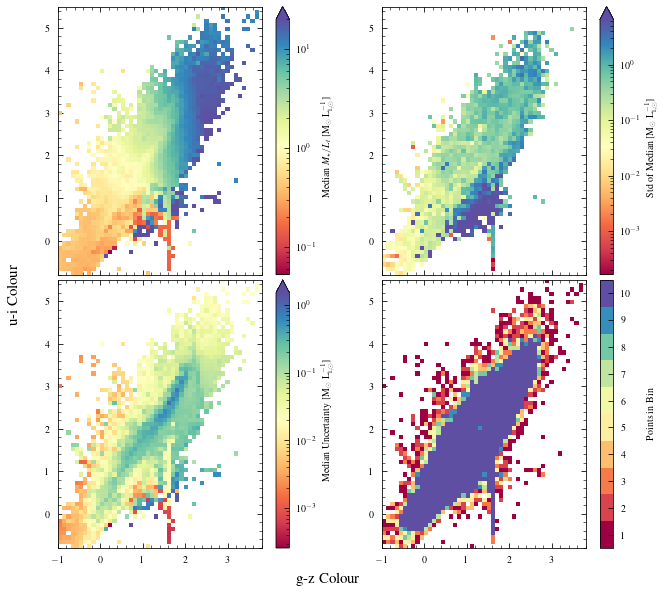

In [6]:
#
# 4-panel plot of MLi, MLi_unc, MLi_std, & points per lookup cell
#
fig, axs = plt.subplots(
    nrows=2, ncols=2, figsize=2*mpl.figure.figaspect(0.95), sharex=True
)
ax1, ax3, ax2, ax4 = axs.flatten()  # top left, bottom left, top right, bottom right
ax_extent = [gz_vals[0], gz_vals[-1], ui_vals[0], ui_vals[-1]]
cbar_fraction = 0.048
# MLi
img1 = ax1.imshow(
    MLi.T,
    extent=ax_extent,
    origin="lower",
    cmap="Spectral",
    norm=mpl.colors.LogNorm(vmax=20),
    zorder=2,
    interpolation="none",
)
cbar1 = fig.colorbar(img1, ax=ax1, fraction=cbar_fraction, extend="max")
cbar1.set_label(f"{avg_func.capitalize()} " + r"$M_\star / L_i$ [$\rm M_\odot\; L_{i, \odot}^{-1}$]")
# ax1.set_ylabel("u-i Colour")
ax1.set_aspect("equal")
ax1.grid(False)
# MLi uncertainty
img2 = ax2.imshow(
    MLi_unc.T,
    extent=ax_extent,
    origin="lower",
    cmap="Spectral",
    norm=mpl.colors.LogNorm(vmax=1.5),
    zorder=2,
    interpolation="none",
)
cbar2 = fig.colorbar(img2, ax=ax2, fraction=cbar_fraction, extend="max")
cbar2.set_label(f"{avg_func.capitalize()} Uncertainty " + r"[$\rm M_\odot\; L_{i, \odot}^{-1}$]")
# ax2.set_xlabel("g-z Colour")
# ax2.set_ylabel("u-i Colour")
ax2.set_xticks(gz_vals[::10])
ax2.set_aspect("equal")
ax2.grid(False)
# Std of MLi
img3 = ax3.imshow(
    MLi_std.T,
    extent=ax_extent,
    origin="lower",
    cmap="Spectral",
    norm=mpl.colors.LogNorm(vmax=np.percentile(MLi_std[np.isfinite(MLi_std)], 95)),
    zorder=2,
    interpolation="none",
    # vmax=np.percentile(MLi_std[np.isfinite(MLi_std)], 95),
)
cbar3 = fig.colorbar(img3, ax=ax3, fraction=cbar_fraction, extend="max")
cbar3.set_label(f"Std of {avg_func.capitalize()} " + r"[$\rm M_\odot\; L_{i, \odot}^{-1}$]")
ax3.tick_params(labelbottom=False)
# ax3.set_ylabel("u-i Colour")
ax3.set_aspect("equal")
ax3.grid(False)
# Data points per colour-colour bin
px_in_bin_masked = np.ma.masked_where(px_in_bin == 0, px_in_bin)
px_in_bin_cmap = mpl.cm.get_cmap("Spectral", 10)
img4 = ax4.imshow(
    px_in_bin_masked.T,
    extent=ax_extent,
    origin="lower",
    cmap=px_in_bin_cmap,
    zorder=2,
    interpolation="none",
    # # To align major ticks in centre of discrete colour bar sections
    vmin=0.5,
    vmax=10.5,
)
cbar4 = fig.colorbar(img4, ax=ax4, fraction=cbar_fraction)
cbar4.set_label(r"Points in Bin", labelpad=15)
cbar4.set_ticks(np.arange(1, 11).astype(int))
cbar4.minorticks_off()
# ax4.set_xlabel("g-z Colour")
ax4.set_xticks(gz_vals[::10])
ax4.set_aspect("equal")
ax4.grid(False)
fig.text(0.53, 0.0, "g-z Colour", ha="center", fontsize=15, color="k")
fig.text(
    0.0,
    0.5,
    "u-i Colour",
    va="center",
    rotation="vertical",
    fontsize=15,
    color="k",
)
plt.subplots_adjust(left=0.001, right=1.0, bottom=0.06, top=1.0, wspace=0.15, hspace=0.02)
# fig.savefig(LOOKUP_PATH + "TOTAL_no4189_extinctionCorr_lookupTable_unc+std+points.pdf")
plt.show()

/tmp/ipykernel_2052/1967115517.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar1 = fig.colorbar(img1, ax=ax1, fraction=0.045, extend="max")
/tmp/ipykernel_2052/1967115517.py:34: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar2 = fig.colorbar(img2, ax=ax2, fraction=0.045, extend="max")


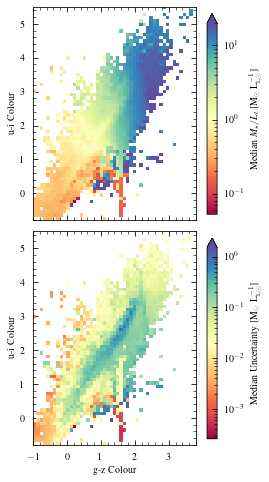

In [7]:
# 
# Only MLi and MLi_unc
# 
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=mpl.figure.figaspect(1.7), sharex=True
)
ax_extent = [gz_vals[0], gz_vals[-1], ui_vals[0], ui_vals[-1]]
# MLi
img1 = ax1.imshow(
    MLi.T,
    extent=ax_extent,
    origin="lower",
    cmap="Spectral",
    norm=mpl.colors.LogNorm(vmax=20),
    zorder=2,
    interpolation="none",
)
cbar1 = fig.colorbar(img1, ax=ax1, fraction=0.045, extend="max")
cbar1.set_label(f"{avg_func.capitalize()} " + r"$M_\star / L_i$ [$\rm M_\odot\; L_{i, \odot}^{-1}$]")
# ax1.set_xlabel("g-z Colour")
ax1.set_ylabel("u-i Colour")
ax1.set_aspect("equal")
ax1.grid(False)
# MLi uncertainty
img2 = ax2.imshow(
    MLi_unc.T,
    extent=ax_extent,
    origin="lower",
    cmap="Spectral",
    norm=mpl.colors.LogNorm(vmax=1.5),
    zorder=2,
    interpolation="none",
)
cbar2 = fig.colorbar(img2, ax=ax2, fraction=0.045, extend="max")
cbar2.set_label(f"{avg_func.capitalize()} Uncertainty " + r"[$\rm M_\odot\; L_{i, \odot}^{-1}$]")
ax2.set_xlabel("g-z Colour")
ax2.set_ylabel("u-i Colour")
ax2.set_xticks(gz_vals[::10])
ax2.set_aspect("equal")
ax2.grid(False)
fig.tight_layout()
# fig.savefig(LOOKUP_PATH + "TOTAL_no4189_extinctionCorr_lookupTable_unc.pdf")
plt.show()

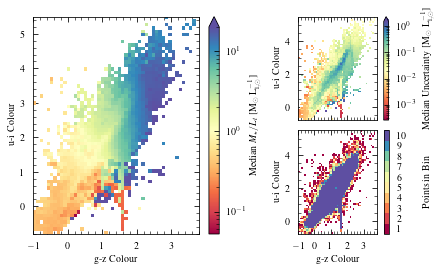

In [4]:
# 
# MLi, MLi_unc, and px_in_bin
# 
ax_extent = [gz_vals[0], gz_vals[-1], ui_vals[0], ui_vals[-1]]
fig = plt.figure(figsize=mpl.figure.figaspect(0.6))
grid = plt.GridSpec(nrows=2, ncols=2, hspace=0.1, width_ratios=[1.5, 1])
MLi_ax = fig.add_subplot(grid[:, 0])
px_in_bin_ax = fig.add_subplot(grid[1, 1])
MLi_unc_ax = fig.add_subplot(grid[0, 1], sharex=px_in_bin_ax)
# MLi
img1 = MLi_ax.imshow(
    MLi.T,
    extent=ax_extent,
    origin="lower",
    cmap="Spectral",
    norm=mpl.colors.LogNorm(vmax=20),
    zorder=2,
    interpolation="none",
)
cbar1 = fig.colorbar(img1, ax=MLi_ax, fraction=0.058, extend="max")
# cbar1 = fig.colorbar(img1, ax=MLi_ax, fraction=0.06)
cbar1.set_label(
    f"{avg_func.capitalize()} " + r"$M_\star / L_i$ [$\rm M_\odot\; L_{i, \odot}^{-1}$]",
    labelpad=1,
)
MLi_ax.set_xticks(gz_vals[::10])
MLi_ax.set_xlabel("g-z Colour")
MLi_ax.set_ylabel("u-i Colour")
MLi_ax.set_aspect("equal")
MLi_ax.grid(False)
# MLi uncertainty
img2 = MLi_unc_ax.imshow(
    MLi_unc.T,
    extent=ax_extent,
    origin="lower",
    cmap="Spectral",
    norm=mpl.colors.LogNorm(vmax=1.5),
    zorder=2,
    interpolation="none",
)
cbar2 = fig.colorbar(img2, ax=MLi_unc_ax, fraction=0.045, extend="max")
cbar2.set_label(f"{avg_func.capitalize()} Uncertainty " + r"[$\rm M_\odot\; L_{i, \odot}^{-1}$]")
MLi_unc_ax.tick_params(labelbottom=False)
MLi_unc_ax.set_ylabel("u-i Colour")
MLi_unc_ax.set_aspect("equal")
MLi_unc_ax.grid(False)
# Data points per colour-colour bin
px_in_bin_masked = np.ma.masked_where(px_in_bin == 0, px_in_bin)
px_in_bin_cmap = mpl.cm.get_cmap("Spectral", 10)
img3 = px_in_bin_ax.imshow(
    px_in_bin_masked.T,
    extent=ax_extent,
    origin="lower",
    cmap=px_in_bin_cmap,
    zorder=2,
    interpolation="none",
    # # To align major ticks in centre of discrete colour bar sections
    vmin=0.5,
    vmax=10.5,
)
cbar3 = fig.colorbar(img3, ax=px_in_bin_ax, fraction=0.045)
cbar3.set_label(r"Points in Bin", labelpad=15)
cbar3.set_ticks(np.arange(1, 11).astype(int))
# cbar3.minorticks_off()
cbar3.ax.tick_params(which="both", length=0)
px_in_bin_ax.set_xlabel("g-z Colour")
px_in_bin_ax.set_ylabel("u-i Colour")
px_in_bin_ax.set_xticks(gz_vals[::10])
px_in_bin_ax.set_aspect("equal")
px_in_bin_ax.grid(False)
# fig.savefig(LOOKUP_PATH + "TOTAL_no4189_extinctionCorr_lookupTable_unc+points.pdf")
plt.show()

In [30]:
print(np.nanmax(MLi_std), np.nanmin(MLi_std), np.nanmedian(MLi_std), np.nanmean(MLi_std), np.percentile(MLi_std[np.isfinite(MLi_std)], 95))
print(np.nanmax(MLi), np.nanmin(MLi), np.nanmedian(MLi), np.nanmean(MLi), np.percentile(MLi[np.isfinite(MLi)], 96.5))
print(np.nanmax(MLi_unc), np.nanmin(MLi_unc), np.nanmedian(MLi_unc), np.nanmean(MLi_unc), np.percentile(MLi_unc[np.isfinite(MLi_unc)], 99.9))

20.941783860571764 0.0 0.27580903343857843 1.1232357022007573 6.545596827828875
88.77783268103283 0.052635825562543134 2.6738053875252454 6.153489317191816 19.931292819489993
2.6364688565475323 0.0002601917020966409 0.04894586816308603 0.10396636157037539 1.5444143793954344


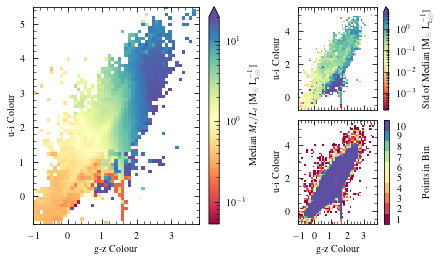

In [23]:
# 
# MLi, MLi_std, and px_in_bin
# 
ax_extent = [gz_vals[0], gz_vals[-1], ui_vals[0], ui_vals[-1]]
fig = plt.figure(figsize=mpl.figure.figaspect(0.6))
grid = plt.GridSpec(nrows=2, ncols=2, hspace=0.1, width_ratios=[1.5, 1])
MLi_ax = fig.add_subplot(grid[:, 0])
px_in_bin_ax = fig.add_subplot(grid[1, 1])
MLi_unc_ax = fig.add_subplot(grid[0, 1], sharex=px_in_bin_ax)
# MLi
img1 = MLi_ax.imshow(
    MLi.T,
    extent=ax_extent,
    origin="lower",
    cmap="Spectral",
    norm=mpl.colors.LogNorm(vmax=20),  # roughly 96.5th percentile
    zorder=2,
    interpolation="none",
)
cbar1 = fig.colorbar(img1, ax=MLi_ax, fraction=0.058, extend="max")
# cbar1 = fig.colorbar(img1, ax=MLi_ax, fraction=0.06)
cbar1.set_label(
    f"{avg_func.capitalize()} " + r"$M_\star / L_i$ [$\rm M_\odot\; L_{i, \odot}^{-1}$]",
    labelpad=1,
)
MLi_ax.set_xticks(gz_vals[::10])
MLi_ax.set_xlabel("g-z Colour")
MLi_ax.set_ylabel("u-i Colour")
MLi_ax.set_aspect("equal")
MLi_ax.grid(False)
# Std of MLi
img2 = MLi_unc_ax.imshow(
    MLi_std.T,
    extent=ax_extent,
    origin="lower",
    cmap="Spectral",
    norm=mpl.colors.LogNorm(vmax=np.percentile(MLi_std[np.isfinite(MLi_std)], 95)),
    zorder=2,
    interpolation="none",
    # vmax=np.percentile(MLi_std[np.isfinite(MLi_std)], 95),
)
cbar2 = fig.colorbar(img2, ax=MLi_unc_ax, fraction=0.045, extend="max")
cbar2.set_label(f"Std of {avg_func.capitalize()} " + r"[$\rm M_\odot\; L_{i, \odot}^{-1}$]")
MLi_unc_ax.tick_params(labelbottom=False)
MLi_unc_ax.set_ylabel("u-i Colour")
MLi_unc_ax.set_aspect("equal")
MLi_unc_ax.grid(False)
# Data points per colour-colour bin
px_in_bin_masked = np.ma.masked_where(px_in_bin == 0, px_in_bin)
px_in_bin_cmap = mpl.cm.get_cmap("Spectral", 10)
img3 = px_in_bin_ax.imshow(
    px_in_bin_masked.T,
    extent=ax_extent,
    origin="lower",
    cmap=px_in_bin_cmap,
    zorder=2,
    interpolation="none",
    # # To align major ticks in centre of discrete colour bar sections
    vmin=0.5,
    vmax=10.5,
)
cbar3 = fig.colorbar(img3, ax=px_in_bin_ax, fraction=0.045)
cbar3.set_label(r"Points in Bin", labelpad=15)
cbar3.set_ticks(np.arange(1, 11).astype(int))
# cbar3.minorticks_off()
cbar3.ax.tick_params(which="both", length=0)
px_in_bin_ax.set_xlabel("g-z Colour")
px_in_bin_ax.set_ylabel("u-i Colour")
px_in_bin_ax.set_xticks(gz_vals[::10])
px_in_bin_ax.set_aspect("equal")
px_in_bin_ax.grid(False)
# fig.savefig(LOOKUP_PATH + "TOTAL_no4189_extinctionCorr_lookupTable_std+points.pdf")
plt.show()

/opt/conda/lib/python3.8/contextlib.py:113: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  return next(self.gen)


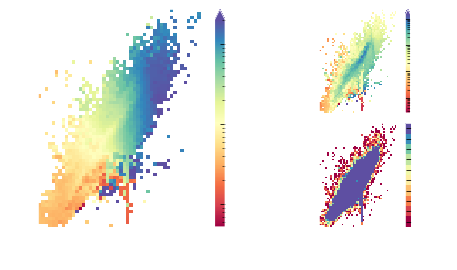

In [3]:
# 
# VERSION FOR BEAMER: MLi, MLi_unc, and px_in_bin
# 
ax_extent = [gz_vals[0], gz_vals[-1], ui_vals[0], ui_vals[-1]]
with plt.style.context("/arc/home/IsaacCheng/coop_f2021/stylesheets/beamer.mplstyle"):
    fig = plt.figure(figsize=mpl.figure.figaspect(0.55))
    grid = plt.GridSpec(nrows=2, ncols=2, hspace=0.1, width_ratios=[1.5, 1])
    MLi_ax = fig.add_subplot(grid[:, 0])
    px_in_bin_ax = fig.add_subplot(grid[1, 1])
    MLi_unc_ax = fig.add_subplot(grid[0, 1], sharex=px_in_bin_ax)
    # MLi
    img1 = MLi_ax.imshow(
        MLi.T,
        extent=ax_extent,
        origin="lower",
        cmap="Spectral",
        norm=mpl.colors.LogNorm(vmax=20),
        zorder=2,
        interpolation="none",
    )
    cbar1 = fig.colorbar(img1, ax=MLi_ax, fraction=0.0585, extend="max")
    # cbar1 = fig.colorbar(img1, ax=MLi_ax, fraction=0.06)
    cbar1.set_label(
        f"{avg_func.capitalize()} " + r"$M_\star / L_i$ [$\rm M_\odot\; L_{i, \odot}^{-1}$]",
        labelpad=1,
    )
    MLi_ax.set_xticks(gz_vals[::10])
    MLi_ax.set_xlabel("g-z Colour")
    MLi_ax.set_ylabel("u-i Colour")
    MLi_ax.set_aspect("equal")
    MLi_ax.grid(False)
    # MLi uncertainty
    img2 = MLi_unc_ax.imshow(
        MLi_unc.T,
        extent=ax_extent,
        origin="lower",
        cmap="Spectral",
        norm=mpl.colors.LogNorm(vmax=1.5),
        zorder=2,
        interpolation="none",
    )
    cbar2 = fig.colorbar(img2, ax=MLi_unc_ax, fraction=0.045, extend="max")
    cbar2.set_label(
        f"{avg_func.capitalize()} Uncertainty " + r"[$\rm M_\odot\; L_{i, \odot}^{-1}$]",
        size=8,
        labelpad=0,
    )
    cbar2.ax.tick_params(labelsize=8)
    # cbar2.set_ticks([1e1, 1e2, 1e3, 1e4])
    MLi_unc_ax.tick_params(labelbottom=False)
    MLi_unc_ax.set_ylabel("u-i Colour")
    MLi_unc_ax.set_aspect("equal")
    MLi_unc_ax.grid(False)
    # Data points per colour-colour bin
    px_in_bin_masked = np.ma.masked_where(px_in_bin == 0, px_in_bin)
    px_in_bin_cmap = mpl.cm.get_cmap("Spectral", 10)
    img3 = px_in_bin_ax.imshow(
        px_in_bin_masked.T,
        extent=ax_extent,
        origin="lower",
        cmap=px_in_bin_cmap,
        zorder=2,
        interpolation="none",
        # # To align major ticks in centre of discrete colour bar sections
        vmin=0.5,
        vmax=10.5,
    )
    cbar3 = fig.colorbar(img3, ax=px_in_bin_ax, fraction=0.045)
    cbar3.set_label(
        r"Points in Bin",
        size=8,
        labelpad=12,
    )
    cbar3.ax.tick_params(labelsize=8)
    cbar3.set_ticks(np.arange(1, 11).astype(int))
    cbar3.minorticks_off()
    # cbar3.ax.tick_params(which="both", length=0)
    px_in_bin_ax.set_xlabel("g-z Colour")
    px_in_bin_ax.set_ylabel("u-i Colour")
    px_in_bin_ax.set_xticks(gz_vals[::10])
    px_in_bin_ax.set_aspect("equal")
    px_in_bin_ax.grid(False)
    # Set colorbar ticks to black
    for cbar in [cbar1, cbar2, cbar3]:
        cbar.ax.yaxis.set_tick_params(color="k", which="both")
    # fig.savefig(LOOKUP_PATH + "TOTAL_no4189_extinctionCorr_lookupTable_unc+points_beamer.pdf")
    plt.show()

/opt/conda/lib/python3.8/contextlib.py:113: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  return next(self.gen)


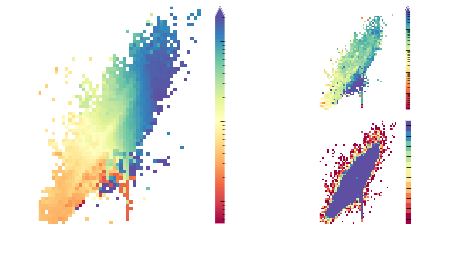

In [4]:
# 
# VERSION FOR BEAMER: MLi, MLi_std, and px_in_bin
# 
ax_extent = [gz_vals[0], gz_vals[-1], ui_vals[0], ui_vals[-1]]
with plt.style.context("/arc/home/IsaacCheng/coop_f2021/stylesheets/beamer.mplstyle"):
    fig = plt.figure(figsize=mpl.figure.figaspect(0.55))
    grid = plt.GridSpec(nrows=2, ncols=2, hspace=0.1, width_ratios=[1.5, 1])
    MLi_ax = fig.add_subplot(grid[:, 0])
    px_in_bin_ax = fig.add_subplot(grid[1, 1])
    MLi_unc_ax = fig.add_subplot(grid[0, 1], sharex=px_in_bin_ax)
    # MLi
    img1 = MLi_ax.imshow(
        MLi.T,
        extent=ax_extent,
        origin="lower",
        cmap="Spectral",
        norm=mpl.colors.LogNorm(vmax=20),
        zorder=2,
        interpolation="none",
    )
    cbar1 = fig.colorbar(img1, ax=MLi_ax, fraction=0.0585, extend="max")
    # cbar1 = fig.colorbar(img1, ax=MLi_ax, fraction=0.06)
    cbar1.set_label(
        f"{avg_func.capitalize()} " + r"$M_\star / L_i$ [$\rm M_\odot\; L_{i, \odot}^{-1}$]",
        labelpad=1,
    )
    MLi_ax.set_xticks(gz_vals[::10])
    MLi_ax.set_xlabel("g-z Colour")
    MLi_ax.set_ylabel("u-i Colour")
    MLi_ax.set_aspect("equal")
    MLi_ax.grid(False)
    # Std of MLi
    img2 = MLi_unc_ax.imshow(
        MLi_std.T,
        extent=ax_extent,
        origin="lower",
        cmap="Spectral",
        norm=mpl.colors.LogNorm(vmax=np.percentile(MLi_std[np.isfinite(MLi_std)], 95)),
        zorder=2,
        interpolation="none",
        # vmax=np.percentile(MLi_std[np.isfinite(MLi_std)], 95),
    )
    cbar2 = fig.colorbar(img2, ax=MLi_unc_ax, fraction=0.045, extend="max")
    cbar2.set_label(
        f"Std of {avg_func.capitalize()} " + r"[$\rm M_\odot\; L_{i, \odot}^{-1}$]",
        size=8,
        labelpad=0,
    )
    cbar2.ax.tick_params(labelsize=8)
    # cbar2.set_ticks([1e1, 1e2, 1e3, 1e4])
    MLi_unc_ax.tick_params(labelbottom=False)
    MLi_unc_ax.set_ylabel("u-i Colour")
    MLi_unc_ax.set_aspect("equal")
    MLi_unc_ax.grid(False)
    # Data points per colour-colour bin
    px_in_bin_masked = np.ma.masked_where(px_in_bin == 0, px_in_bin)
    px_in_bin_cmap = mpl.cm.get_cmap("Spectral", 10)
    img3 = px_in_bin_ax.imshow(
        px_in_bin_masked.T,
        extent=ax_extent,
        origin="lower",
        cmap=px_in_bin_cmap,
        zorder=2,
        interpolation="none",
        # # To align major ticks in centre of discrete colour bar sections
        vmin=0.5,
        vmax=10.5,
    )
    cbar3 = fig.colorbar(img3, ax=px_in_bin_ax, fraction=0.045)
    cbar3.set_label(
        r"Points in Bin",
        size=8,
        labelpad=12,
    )
    cbar3.ax.tick_params(labelsize=8)
    cbar3.set_ticks(np.arange(1, 11).astype(int))
    cbar3.minorticks_off()
    # cbar3.ax.tick_params(which="both", length=0)
    px_in_bin_ax.set_xlabel("g-z Colour")
    px_in_bin_ax.set_ylabel("u-i Colour")
    px_in_bin_ax.set_xticks(gz_vals[::10])
    px_in_bin_ax.set_aspect("equal")
    px_in_bin_ax.grid(False)
    # Set colorbar ticks to black
    for cbar in [cbar1, cbar2, cbar3]:
        cbar.ax.yaxis.set_tick_params(color="k", which="both")
    # fig.savefig(LOOKUP_PATH + "TOTAL_no4189_extinctionCorr_lookupTable_std+points_beamer.pdf")
    plt.show()